# Load libaries

In [1]:
import matplotlib.pylab as plt
import torch
from torchmetrics import MeanSquaredError
from iterativenn.nn_modules.Sequential1D import Sequential1D
import pytorch_lightning as pl

from iterativenn.utils.model_factory import ModelFactory_callback
from sklearn.ensemble import RandomForestRegressor

torch.set_num_threads(1)

# Introduction

This notebook is intended to be, in as simple a way as possible, a demonstration of multi-layer growing

# Preliminaries

We want this notebook to be as simple and as general as possible, so all problem dependent code will be here.

In [2]:
X_orig_train = torch.load('/home/rcpaffenroth/projects/collaborators/students/mia/XTrain.pt')
Y_orig_train = torch.load('/home/rcpaffenroth/projects/collaborators/students/mia/yTrain.pt')
X_orig_test = torch.load('/home/rcpaffenroth/projects/collaborators/students/mia/XTest.pt')
Y_orig_test = torch.load('/home/rcpaffenroth/projects/collaborators/students/mia/yTest.pt')

# Training size
# To make things faster, we'll only use a subset of the data
train_size = X_orig_train.shape[0]
test_size = X_orig_test.shape[0]

# the batch size to use for all trained models
batch_size = 1024
optimizer_factory = torch.optim.RMSprop
epoch_sequence = [3000, 3000] 
assert len(epoch_sequence) == 2, "epoch_sequence must be of length 2 for the moment"

# learning rate for all trained models
Trained_LS_learning_rate = 0.01*200
Trained_LS_max_epochs = epoch_sequence[0]

# Learning rate for the MLP
MLP_learning_rate = 0.01
MLP_max_epochs = epoch_sequence[0]

# Note, the first and last later sizes are fixed by the number of columns in X and Y
MLP_layer_sizes = [X_orig_train.shape[1], 100, 70, 60, 40, 20, Y_orig_train.shape[1]]
MLP_activation = torch.nn.ELU()

# the INN learning rate
INN_learning_rate = 0.01
# number of times to iterate the INN
INN_iterations = 3
# activation function for the INN
INN_activation = 'ELU'

# # number of hidden values in the INN
# INN_hidden_size = 112

In [3]:
# data for the final summary
initialization_summary = []

# Setup

We do some basic setup and sanity checks.

In [4]:
# We have the correct number of training and test samples
assert X_orig_train.shape[0] == Y_orig_train.shape[0]
assert X_orig_test.shape[0] == Y_orig_test.shape[0]

# We have the same number of features in the training and test sets
assert X_orig_train.shape[1] == X_orig_test.shape[1]
assert Y_orig_train.shape[1] == Y_orig_test.shape[1]

In [5]:
print('training data orig shape:')
print (f'X {X_orig_train.shape}')
print (f'Y {Y_orig_train.shape}')

print('testing data orig shape:')
print (f'X {X_orig_test.shape}')
print (f'Y {Y_orig_test.shape}')

training data orig shape:
X torch.Size([13040, 160])
Y torch.Size([13040, 1])
testing data orig shape:
X torch.Size([3260, 160])
Y torch.Size([3260, 1])


In [6]:
perm = torch.randperm(X_orig_train.shape[0])
idx = perm[:train_size]
X_train = X_orig_train[idx, :]
Y_train = Y_orig_train[idx, :]

In [7]:
perm = torch.randperm(X_orig_test.shape[0])
idx = perm[:test_size]
X_test = X_orig_test[idx, :]
Y_test = Y_orig_test[idx, :]

In [8]:
print('training data shape:')
print (f'X {X_train.shape}')
print (f'Y {Y_train.shape}')

print('testing data shape:')
print (f'X {X_test.shape}')
print (f'Y {Y_test.shape}')

training data shape:
X torch.Size([13040, 160])
Y torch.Size([13040, 1])
testing data shape:
X torch.Size([3260, 160])
Y torch.Size([3260, 1])


# Functions

In [9]:
def least_squares(X, Y, device=None, dtype=None):
    """
    Returns a Linear object that is the least squares solution to the problem X -> Y.
    This function initializes the initial weights "weight_0" and the update "U" 
    to be the optimal least squares solution to the linear regression problem
    which maps the input X to the output Y.  This is done by computing

    :math:`
        XW=Y\\
        X^T X W = X^T Y \\
        (X^T X)^{-1} X^T X W = (X^T X)^{-1} X^T Y \\
        W = (X^T X)^{-1} X^T Y 
    `
    Args:
    X: A tensor of shape (N, D) where N is the number of samples and D is the number of features.
    Y: A tensor of shape (N, K) where N is the number of samples and K is the number of outputs.
    device: The device to use for the Linear object.
    dtype: The dtype to use for the Linear object.
    """
    X_size = X.shape[1]
    Y_size = Y.shape[1]
    A = torch.nn.Linear(in_features=X_size, out_features=Y_size, bias=False, device=device, dtype=dtype)
    with torch.no_grad():
        W_init = (torch.inverse(X.T @ X)@X.T@Y).T
        # The requires_grad=Fase is important, otherwise the gradient will be computed when we don't want it to.
        A.weight[:, :] = W_init
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(A(X), Y) 
    A.losses = [float(loss)] * (epoch_sequence[0] * X_train.shape[0] // batch_size)
    return A

In [10]:
class SklearnModule(torch.nn.Module):
    def __init__(self, sklearn_method, in_features, out_features):
        super().__init__()
        self.sklearn_method = sklearn_method
        self.in_features = in_features
        self.out_features = out_features
        self.losses = []
    
    def forward(self, X):
        with torch.no_grad():
            result = torch.tensor(self.sklearn_method.predict(X.detach().cpu().numpy()))
        return result

In [11]:
def sklearn_solver(X, Y):
    """
    Returns a pytorch lightning model that wraps a sklearn model.
    """
    sklearn_method = RandomForestRegressor(n_estimators=20, max_depth=20)
    with torch.no_grad():
        sklearn_method.fit(X, Y.view(-1))
    A = SklearnModule(sklearn_method, X.shape[1], Y.shape[1])
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(A(X), Y) 
    A.losses = [float(loss)] * (epoch_sequence[0] * X_train.shape[0] // batch_size)
    return A

In [12]:
class LitModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.in_features = model.in_features
        self.out_features = model.out_features
        self.learning_rate = learning_rate
        self.losses = []
    
    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        X,Y = batch
        Y_hat = self.model(X)
        # Both are training on the MSE loss (not RMSE)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        self.losses.append(float(loss))
        return loss
    
    def configure_optimizers(self):
        optimizer = optimizer_factory(self.parameters(), lr=self.learning_rate)
        return optimizer

In [13]:
class LitIteratedModule(pl.LightningModule):
    def __init__(self, model, callbacks, learning_rate, iterations=1):
        super().__init__()
        self.model = model
        self.in_features = model.in_features
        self.out_features = model.out_features
        self.callbacks = callbacks
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.losses = []
    
    def forward(self, X):
        Z = self.callbacks.initialization(X.device, rows=X.shape[0])
        Z = self.callbacks.data(Z, X, 0, None)
        for i in range(self.iterations):
            Z = self.model(Z)
        return self.callbacks.output(Z, 0, None, None)

    def training_step(self, batch, batch_idx):
        X,Y = batch
        Z = self.callbacks.initialization(X.device, rows=X.shape[0])
        Z = self.callbacks.data(Z, X, 0, None)
        # Note, the lost is returned for every iteration.
        # Sometimes it might be 0 (e.g., when loss type is 'last')
        loss = 0
        for i in range(self.iterations):
            Z = self.model(Z)        
            # Both are training on the MSE loss (not RMSE)
            loss += self.callbacks.loss(Z, Y, i, range(self.iterations))
        self.losses.append(float(loss))
        return loss    

    def configure_optimizers(self):
        optimizer = optimizer_factory(self.parameters(), lr=self.learning_rate)
        return optimizer

In [14]:
def get_cfg(previous_model, k, grow_weight_std=0.01, ):
    default_kwargs = {'block_type':'W', 'initialization_type':f'G=0.0,{grow_weight_std}', 'trainable':True, 'bias':False}
    default_kwargs_0 = {'block_type':'W', 'initialization_type':f'G=0.0,0.0', 'trainable':True, 'bias':False}

    m = previous_model.in_features
    n = previous_model.out_features

    default_model = 'MaskedLinear.from_description'
    print(f'predicted INN_trainable_params: {m*k+2*n*k+k**2}')
    cfg = {
        "model_type": "sequential2D",   
        "in_features_list": [m, n, k], 
        "out_features_list": [m, n, k], 

        "activations" : ['Identity', 'Identity', INN_activation],
        "activation_sizes" : [m, n, k],
        "callbacks": {
            "loss": {
                "func": "MSELoss",
                "idx_list" : range(m, m+n),
                # Change this to 'all' to use all the losses during the iteration
                # "sequence_position": 'all',
                "sequence_position": 'last',
            },
            "initialization": {
                "func": "zeros",
                "size": m+n+k,
            },
            "data": {
                "func": "insert",
                "idx_list": range(0, m),
                "flatten_input": False,
            },
            "output": {
                "func": "all",
                "idx_list" : range(m, m+n)
            },
        }
    }
    cfg["block_types"] = [
            ['Identity',     'Module',       default_model],
            [None,           None,           default_model],
            [None,           default_model, default_model]]
    cfg["block_kwargs"] = [
            [None,           {'module':previous_model, 'trainable': False}, default_kwargs],
            [None,           None,                                           default_kwargs],
            [None,           default_kwargs_0,                                 default_kwargs]]
    return cfg

In [15]:
def evaluate_models(models, names, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test):
    legends_loss = []
    rmse = MeanSquaredError(squared=False)
    f, ax = plt.subplots(ncols=2, figsize=(12, 6))
    for model, name in zip(models, names):
        ax[0].plot(model.losses)
        ax[1].semilogy(model.losses)
        legends_loss.append(name)

    ax[0].set_xlabel('Step')
    ax[0].set_ylabel('Loss')
    ax[0].legend(legends_loss)
    ax[1].set_xlabel('Step')
    ax[1].set_ylabel('Loss')
    ax[1].legend(legends_loss)

    f.tight_layout()

In [16]:
def train_model(model, max_epochs):
    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    trainer = pl.Trainer(max_epochs=max_epochs,
                         devices=1 if torch.cuda.is_available() else None,
                         accelerator='auto')
    trainer.fit(model=model, train_dataloaders=train_dataloader)

# Compute initialization models

## Least squares initial model

In [17]:
least_squares_model = least_squares(X_train, Y_train)

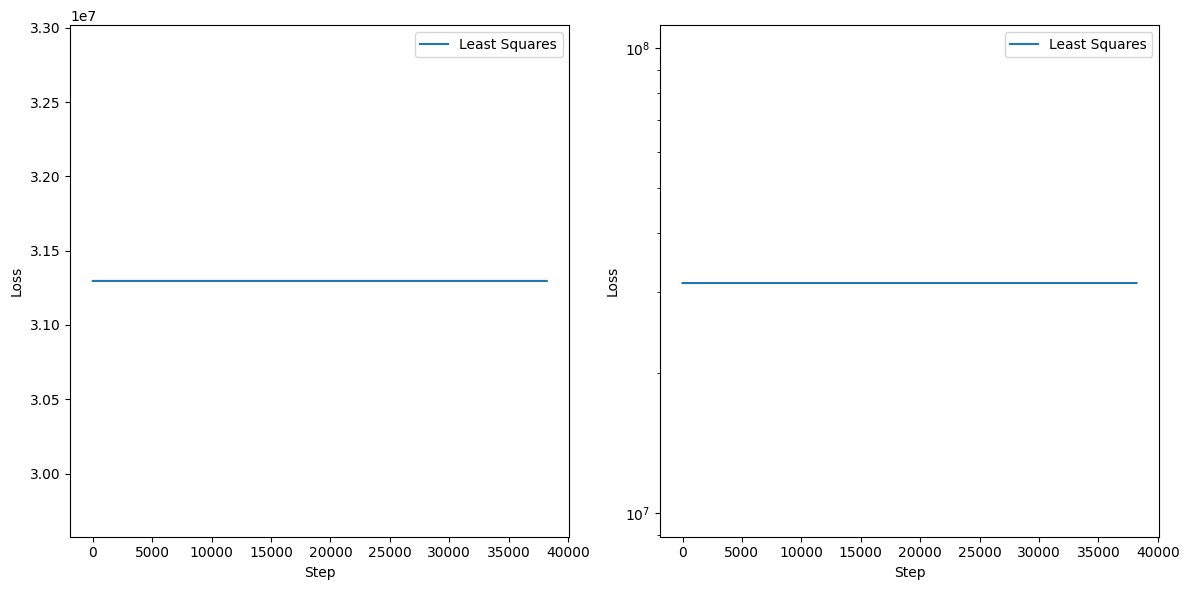

In [18]:
evaluate_models([least_squares_model], ['Least Squares'])

In [19]:
initialization_dict = {}
initialization_dict['model'] = least_squares_model
initialization_dict['name'] = 'Least Squares'
initialization_dict['trainable parameters'] = 0
initialization_summary.append(initialization_dict)

## Random forest initial model

In [20]:
sklearn_model = sklearn_solver(X_train, Y_train)

/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13040, 1])) that is different to the input size (torch.Size([13040])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


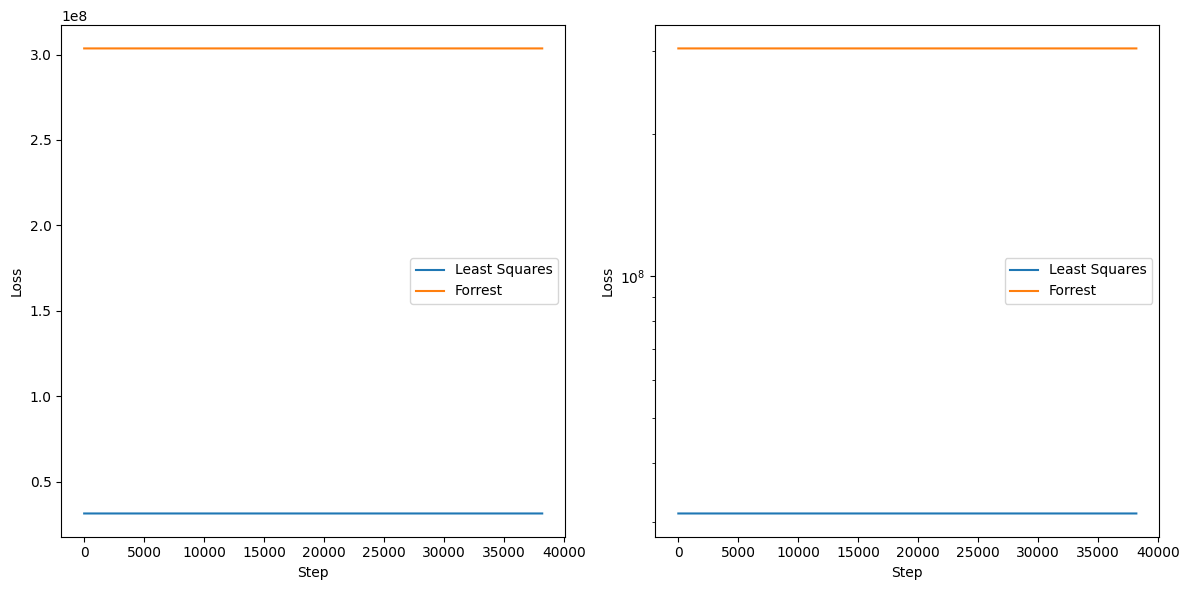

In [21]:
evaluate_models([least_squares_model, sklearn_model], ['Least Squares', 'Forrest'])

In [22]:
initialization_dict = {}
initialization_dict['model'] = sklearn_model
initialization_dict['name'] = 'Random Forrest'
initialization_dict['trainable parameters'] = 0
initialization_summary.append(initialization_dict)

## Trained least squares initial model

In [23]:
# Sequential1D is just a wrapper around nn.Sequential that
# records the input and output sizes of the network.  This is useful
# for the INN solution below as the MLP can be used as a block in an INN.
# However, the as far as this part is concerned, it is identical to nn.Sequential.
trained_least_squares = Sequential1D(in_features=MLP_layer_sizes[0],
                                     out_features=MLP_layer_sizes[-1]) 

trained_least_squares.add_module('linear0', torch.nn.Linear(X_train.shape[1], Y_train.shape[1], bias=False))
trained_least_squares_model = LitModule(trained_least_squares, learning_rate=Trained_LS_learning_rate)

In [24]:
train_model(trained_least_squares_model, Trained_LS_max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type         | Params
---------------------------------------
0 | model | Sequential1D | 160   
---------------------------------------
160       Trainable params
0         Non-trainable params
160       Total params
0.001     Total estimated model params size (MB)
/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dat

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3000` reached.


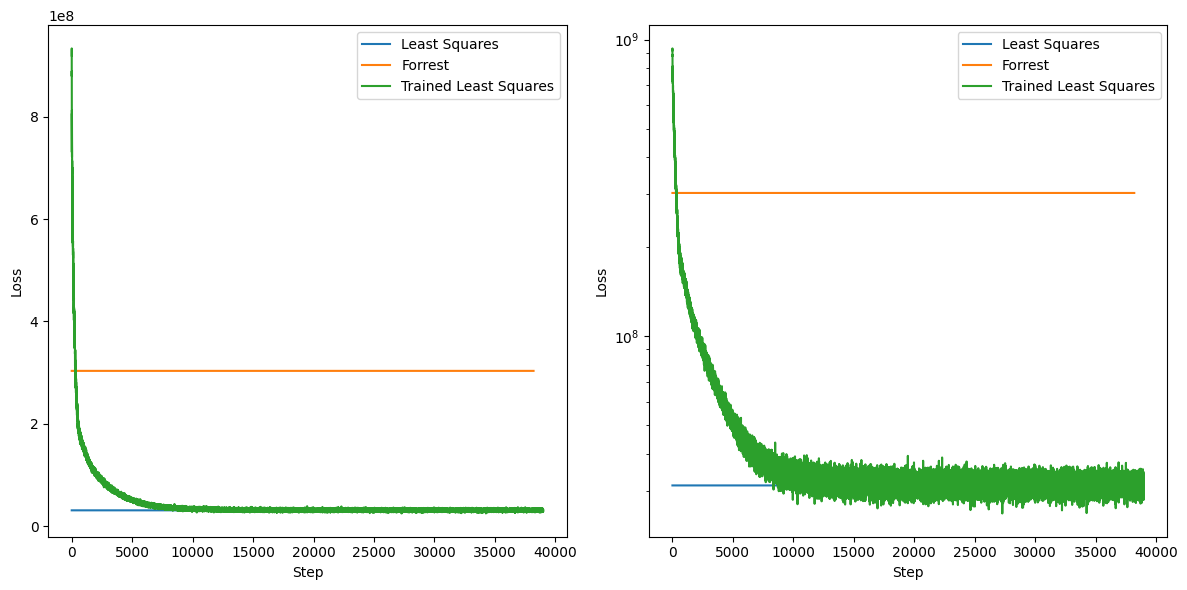

In [25]:
evaluate_models([least_squares_model, sklearn_model, trained_least_squares_model], ['Least Squares', 'Forrest', 'Trained Least Squares'])

In [26]:
initialization_dict = {}
initialization_dict['model'] = trained_least_squares_model
initialization_dict['name'] = 'Trained Least Squares'
initialization_dict['trainable parameters'] = sum(p.numel() for p in initialization_dict['model'].parameters() if p.requires_grad)
initialization_summary.append(initialization_dict)

## MLP initial model

In [27]:
# Sequential1D is just a wrapper around nn.Sequential that
# records the input and output sizes of the network.  This is useful
# for the INN solution below as the MLP can be used as a block in an INN.
# However, the as far as this part is concerned, it is identical to nn.Sequential.
mlp = Sequential1D(in_features=MLP_layer_sizes[0],
                   out_features=MLP_layer_sizes[-1]) 

for i in range(len(MLP_layer_sizes)-1):
    mlp.add_module(f'linear{i}', 
                   torch.nn.Linear(MLP_layer_sizes[i], MLP_layer_sizes[i+1]))
    # always end with a linear layer
    if i < len(MLP_layer_sizes)-2:        
        mlp.add_module(f'activation{i}', 
                       MLP_activation)
mlp_model = LitModule(mlp, MLP_learning_rate)


In [28]:
train_model(mlp_model, MLP_max_epochs)
torch.save(mlp_model, 'mlp_model.pt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type         | Params
---------------------------------------
0 | model | Sequential1D | 30.7 K
---------------------------------------
30.7 K    Trainable params
0         Non-trainable params
30.7 K    Total params
0.123     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3000` reached.


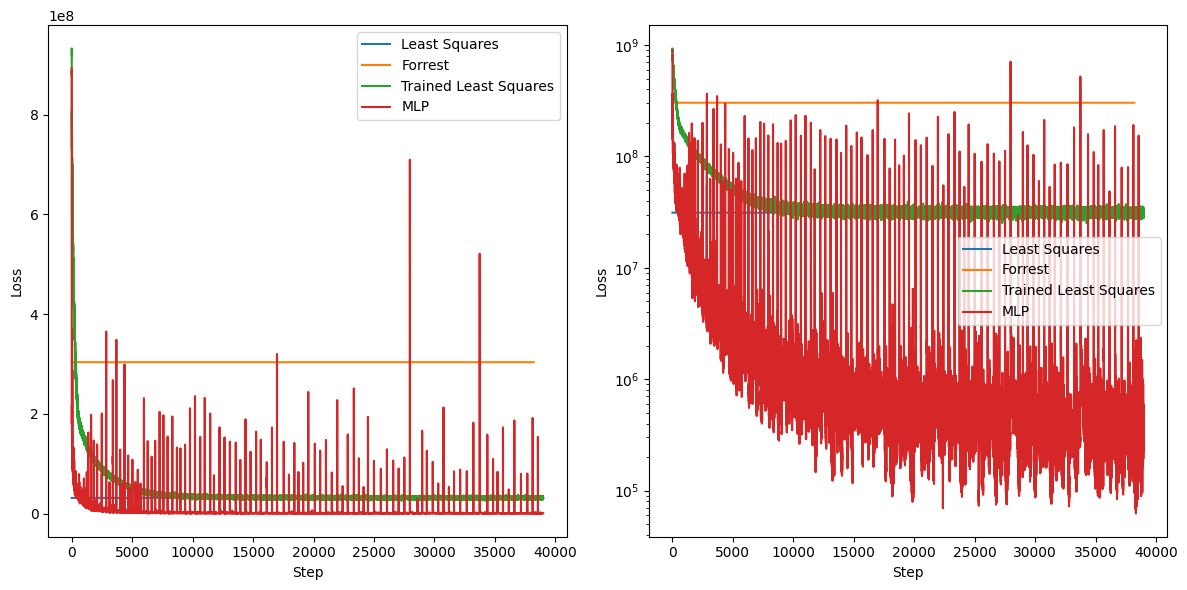

In [29]:
evaluate_models([least_squares_model, sklearn_model, trained_least_squares_model, mlp_model], ['Least Squares', 'Forrest', 'Trained Least Squares', 'MLP'])

In [30]:
initialization_dict = {}
initialization_dict['model'] = mlp_model
initialization_dict['name'] = 'MLP'
initialization_dict['trainable parameters'] = sum(p.numel() for p in initialization_dict['model'].parameters() if p.requires_grad)
initialization_summary.append(initialization_dict)

# MLP comparison module

In [31]:
summary = []

In [32]:
# Sequential1D is just a wrapper around nn.Sequential that
# records the input and output sizes of the network.  This is useful
# for the INN solution below as the MLP can be used as a block in an INN.
# However, the as far as this part is concerned, it is identical to nn.Sequential.
mlp_comparison = Sequential1D(in_features=MLP_layer_sizes[0],
                   out_features=MLP_layer_sizes[-1]) 

for i in range(len(MLP_layer_sizes)-1):
    mlp_comparison.add_module(f'linear{i}', 
                   torch.nn.Linear(MLP_layer_sizes[i], MLP_layer_sizes[i+1]))
    # always end with a linear layer
    if i < len(MLP_layer_sizes)-2:        
        mlp_comparison.add_module(f'activation{i}', 
                       MLP_activation)
mlp_comparison_model = LitModule(mlp_comparison, MLP_learning_rate)

In [33]:
train_model(mlp_comparison_model, sum(epoch_sequence))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type         | Params
---------------------------------------
0 | model | Sequential1D | 30.7 K
---------------------------------------
30.7 K    Trainable params
0         Non-trainable params
30.7 K    Total params
0.123     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=6000` reached.


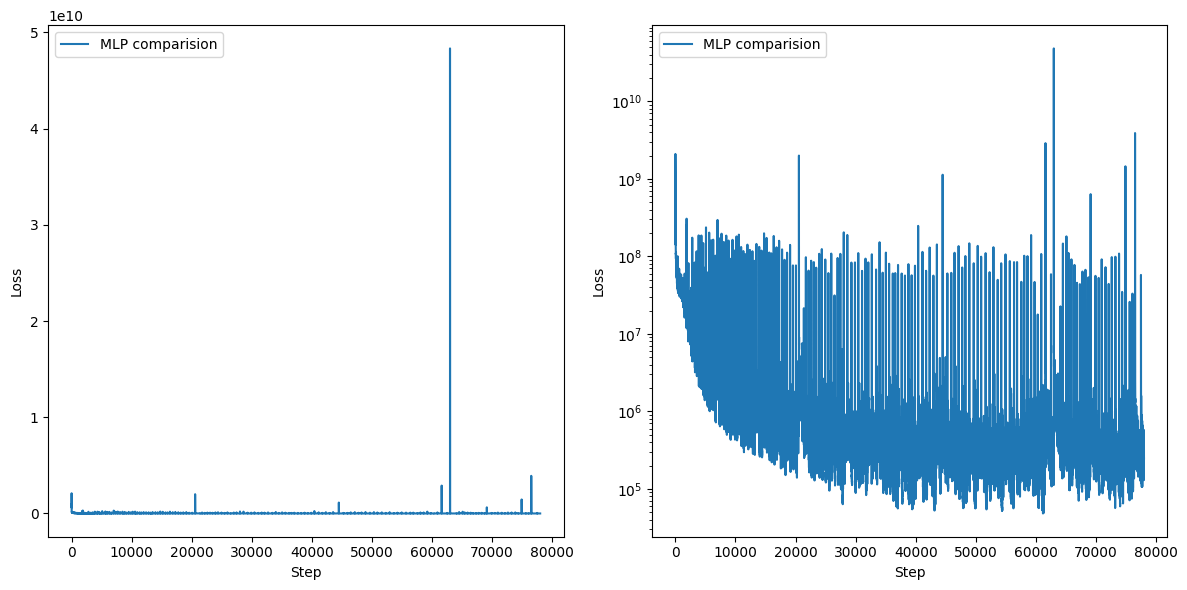

In [34]:
evaluate_models([mlp_comparison_model], ['MLP comparision'])

In [35]:
model_dict = {}
model_dict['model'] = mlp_comparison_model
model_dict['name'] = 'MLP'
model_dict['trainable parameters'] = sum(p.numel() for p in model_dict['model'].parameters() if p.requires_grad)
summary.append(model_dict)

# INN solution, least squares grown

In [36]:
# The starting module
start_model = least_squares_model
model = least_squares_model
grow_sequence = [None, 112]
assert len(grow_sequence) == len(epoch_sequence), 'The grow sequence and epoch sequence must be the same length'

for i,k in enumerate(grow_sequence):
    if i > 0:
        # Make a new module with another band of unknowns
        grown_model = ModelFactory_callback(get_cfg(model, k))
        grown_model = LitIteratedModule(grown_model.model, grown_model.callbacks, INN_learning_rate, iterations=INN_iterations)
        assert i <= 1, "To do this correctly, we need to have to have the callbacks at one level call the callbacks at the previous level"
        train_model(grown_model, epoch_sequence[i])
        model = grown_model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type         | Params
---------------------------------------
0 | model | Sequential1D | 92.2 K
---------------------------------------
30.7 K    Trainable params
61.5 K    Non-trainable params
92.2 K    Total params
0.369     Total estimated model params size (MB)


predicted INN_trainable_params: 30688


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3000` reached.


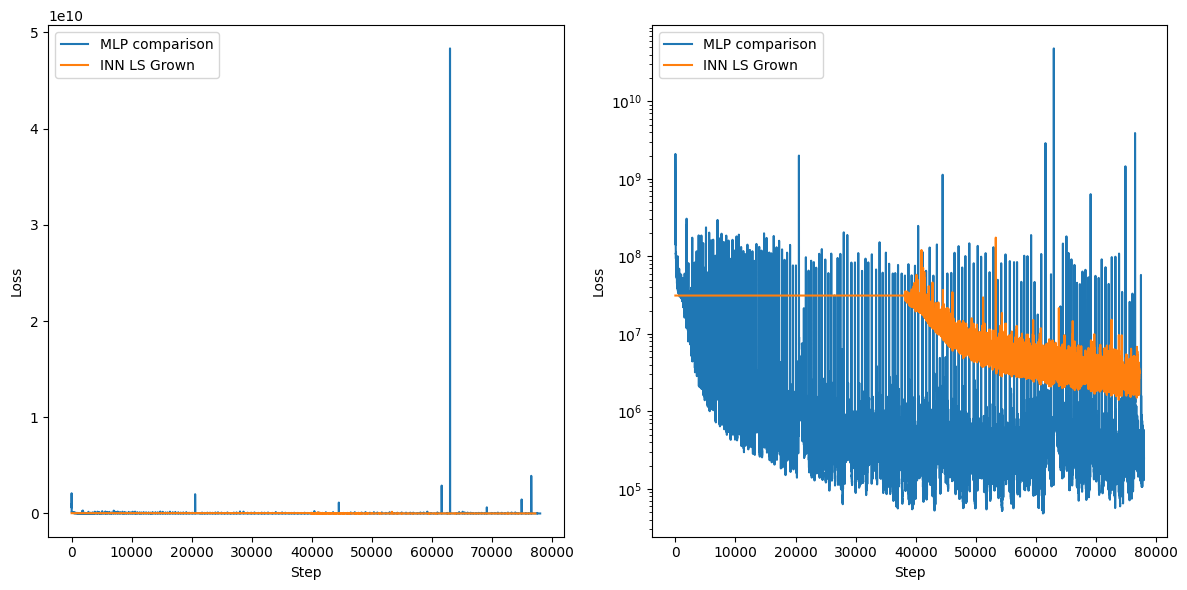

In [37]:
grown_model.losses = start_model.losses + grown_model.losses
evaluate_models([mlp_comparison_model, grown_model], ['MLP comparison', 'INN LS Grown'])

In [38]:
model_dict = {}
model_dict['model'] = grown_model
model_dict['name'] = 'LS Grown'
model_dict['trainable parameters'] = sum(p.numel() for p in model_dict['model'].parameters() if p.requires_grad)
summary.append(model_dict)

# INN solution, MLP grown

In [39]:
# The starting module
mlp_model = torch.load('mlp_model.pt')
start_model = mlp_model
grown_model = mlp_model
grow_sequence = [None, 112]
assert len(grow_sequence) == len(epoch_sequence), 'The grow sequence and epoch sequence must be the same length'

for i,k in enumerate(grow_sequence):
    if i > 0:
        # Make a new module with another band of unknowns
        grown_model = ModelFactory_callback(get_cfg(grown_model, k))
        grown_model = LitIteratedModule(grown_model.model, grown_model.callbacks, INN_learning_rate, iterations=INN_iterations)
        assert i <= 1, "To do this correctly, we need to have to have the callbacks at one level call the callbacks at the previous level"
        train_model(grown_model, epoch_sequence[i])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type         | Params
---------------------------------------
0 | model | Sequential1D | 122 K 
---------------------------------------
30.7 K    Trainable params
92.1 K    Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)


predicted INN_trainable_params: 30688


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3000` reached.


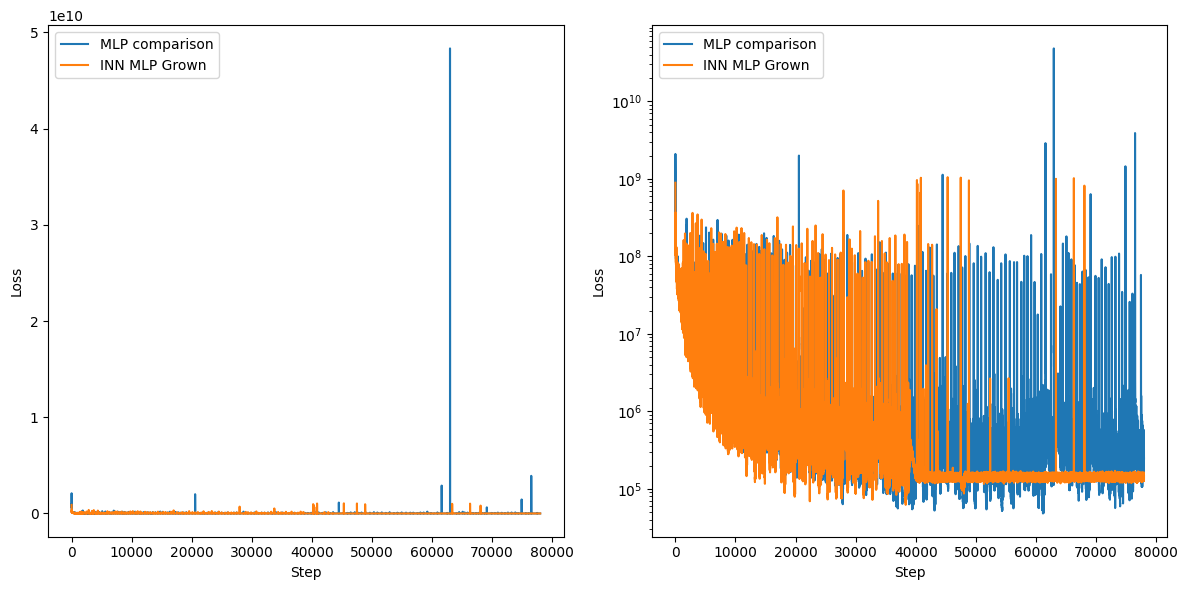

In [40]:
grown_model.losses = start_model.losses + grown_model.losses
evaluate_models([mlp_comparison_model, grown_model], ['MLP comparison', 'INN MLP Grown'])

In [41]:
model_dict = {}
model_dict['model'] = grown_model
model_dict['name'] = 'MLP Grown'
model_dict['trainable parameters'] = sum(p.numel() for p in model_dict['model'].parameters() if p.requires_grad)
summary.append(model_dict)

# Summary

In [42]:
rmse = MeanSquaredError(squared=False)
for summary_dict in summary:
    print(f'{summary_dict["name"]} trainable params: {summary_dict["trainable parameters"]}')
    print(f'{summary_dict["name"]} Training error : {rmse(summary_dict["model"](X_train), Y_train).item()}')
    print(f'{summary_dict["name"]} Testing error : {rmse(summary_dict["model"](X_test), Y_test).item()}')
    print('================================')

MLP trainable params: 30711
MLP Training error : 483.1237487792969
MLP Testing error : 812.0546875
LS Grown trainable params: 30688
LS Grown Training error : 1619.4912109375
LS Grown Testing error : 1893.44091796875
MLP Grown trainable params: 30688
MLP Grown Training error : 377.3612060546875
MLP Grown Testing error : 799.1671142578125
